## Executive Summary:

With consumers becoming more aware and educated about the types of products they use, as well as what they eat, some products are not an obvious health risk at first glance. While there is no guarantee the adverse events reported to the FDA (U.S. Food and Drug Administration) are due to the referenced product, the Center for Food Safety and Applied Nutrition (CFSAN) will monitor these reports to ensure safety for the public. Should there be any concerns, further research is conducted. If needed, the FDA will take action, such as making an announcement to discontinue use of the product. 

To help consumers remain well informed, a recommender system has been created as a way to search whether a product may cause negative reactions. The system will allow a user to enter a product and return a list of 10 other products that reference similar symptoms. Using that information, consumers can reconsider purchasing that list of products going forward. As a result, this empowers consumers to take preventative measures rather than waiting to react to recall announcements, or experience an adverse event first hand.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import string
from sklearn.feature_extraction import stop_words
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [2]:
# prevents warnings from appearing

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load in both datasets
# ref regarding encoding:
    # https://stackoverflow.com/questions/45529507/python-unicodedecodeerror-utf-8-codec-cant-decode-byte-0x96-in-position-35

fda_2004_2013 = pd.read_csv('./datasets/CAERSASCII-2004-2013.csv', encoding = 'cp1252')

In [4]:
# ref regarding encoding:
    # https://stackoverflow.com/questions/45529507/python-unicodedecodeerror-utf-8-codec-cant-decode-byte-0x96-in-position-35
fda_2014_2019 = pd.read_csv('./datasets/CAERSASCII 2014-20190331.csv', encoding = 'ISO-8859-1')

In [5]:
adverse_events = pd.concat([fda_2004_2013, fda_2014_2019], ignore_index=True)

In [6]:
adverse_events.to_csv('./datasets/adverse_events.csv', index= False)

In [7]:
adverse_events.shape

(130079, 12)

In [8]:
# MedDRA = Medical Data Dictionary for Regulatory Activities (symptoms the consumer experienced)

adverse_events.head()

,Report ID,CAERS Created Date,Date of Event,Product Type,Product,Product Code,Description,Patient Age,Age Units,Sex,MedDRA Preferred Terms,Outcomes
0,65335,1/1/2004,11/24/2003,SUSPECT,ENFAMIL LIPIL BABY FORMULA,40,Baby Food Products,3.0,month(s),NaN,"VOMITING, GASTROINTESTINAL DISORDER",Other Outcome
1,65345,1/1/2004,12/21/2003,SUSPECT,"FRITO LAY FUNYUNS ONION FLAVOR, ONION RINGS",07,Snack Food Item,10.0,year(s),M,CHOKING,Other Outcome
2,65350,1/1/2004,NaN,SUSPECT,GRAPE,20,Fruit/Fruit Prod,NaN,NaN,NaN,"DEATH, CHOKING",Death
3,65336,1/1/2004,NaN,SUSPECT,ENFIMIL LIPIL BABY FORMULA,40,Baby Food Products,NaN,NaN,NaN,"PHYSICAL EXAMINATION, GASTROINTESTINAL DISORDER",Patient Visited Healthcare Provider
4,65333,1/1/2004,NaN,SUSPECT,KROGER CLASSIC CREAM-DE-MINT CANDY MINT CHIP I...,13,Ice Cream Prod,NaN,NaN,NaN,"NAUSEA, DYSGEUSIA, DIARRHOEA",Patient Visited ER


In [9]:
adverse_events.dtypes

Report ID                  object
CAERS Created Date         object
Date of Event              object
Product Type               object
Product                    object
Product Code               object
Description                object
Patient Age               float64
Age Units                  object
Sex                        object
MedDRA Preferred Terms     object
Outcomes                   object
dtype: object

In [10]:
# Large number of nulls could be due to volunteers opting not to provide that information when filling out report, 
    # or maybe healthcare providers didn't have that information available for some reason.
# May not need all columns for recommender system.
    # Important columns: Product, Description, MedDRA Preferred Terms
    
adverse_events.isnull().sum()

Report ID                     0
CAERS Created Date            0
Date of Event             70695
Product Type                  0
Product                      10
Product Code               5126
Description                5126
Patient Age               74016
Age Units                 74015
Sex                       75346
MedDRA Preferred Terms     1162
Outcomes                      0
dtype: int64

In [11]:
adverse_events[adverse_events['Product'].isnull()]

,Report ID,CAERS Created Date,Date of Event,Product Type,Product,Product Code,Description,Patient Age,Age Units,Sex,MedDRA Preferred Terms,Outcomes
107829,2017-CFS-002558,12/13/2017,12/11/2017,SUSPECT,NaN,NaN,NaN,NaN,NaN,NaN,"Vomiting, Retching, Malaise, Gastroenteritis v...",Medically Important
113409,2018-CFS-003956,3/8/2018,12/11/2017,SUSPECT,NaN,NaN,NaN,NaN,NaN,NaN,"Vomiting, Retching, Flatulence, Feeling hot, D...",Other Seriousness
115278,2018-CFS-005210,3/29/2018,NaN,SUSPECT,NaN,NaN,NaN,NaN,NaN,NaN,"Gastrointestinal obstruction, Flatulence, Diar...","Hospitalization, Medically Important"
115363,2018-CFS-005277,3/30/2018,NaN,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,"Weight decreased, Decreased appetite",Medically Important
115420,2018-CFS-005326,4/2/2018,3/16/2018,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,Diarrhoea,Medically Important
115426,2018-CFS-005327,4/2/2018,3/28/2018,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,"Palpitations, Flushing",Medically Important
123981,2018-CFS-012850,10/24/2018,9/30/2018,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,Convulsion,Medically Important
125798,2018-CFS-014689,12/17/2018,NaN,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,"Ovarian cancer, Metastasis, Haemorrhagic tumou...",Medically Important
129471,2019-CFS-002822,3/19/2019,12/10/2018,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,Skin discolouration,Disability
129531,2019-CFS-002889,3/20/2019,3/14/2019,CONCOMITANT,NaN,NaN,NaN,NaN,NaN,NaN,"Vomiting, Nausea, Gastroenteritis, Diarrhoea, ...","Hospitalization, Patient Visited ER"


In [12]:
# Need to drop. Not useful when premise is to determine which product(s) consumers should be cautious of purchasing

adverse_events.dropna(subset = ['Product'], inplace = True)

In [13]:
adverse_events.isnull().sum()

Report ID                     0
CAERS Created Date            0
Date of Event             70692
Product Type                  0
Product                       0
Product Code               5116
Description                5116
Patient Age               74006
Age Units                 74005
Sex                       75336
MedDRA Preferred Terms     1162
Outcomes                      0
dtype: int64

In [14]:
adverse_events[adverse_events['MedDRA Preferred Terms'].isnull()]

,Report ID,CAERS Created Date,Date of Event,Product Type,Product,Product Code,Description,Patient Age,Age Units,Sex,MedDRA Preferred Terms,Outcomes
94762,210146,4/12/2017,NaN,SUSPECT,EXEMPTION 4,53,Cosmetics,NaN,NaN,NaN,NaN,Death
94763,210146,4/12/2017,NaN,SUSPECT,EXEMPTION 4,53,Cosmetics,NaN,NaN,NaN,NaN,Death
94789,210147,4/12/2017,NaN,SUSPECT,EXEMPTION 4,53,Cosmetics,NaN,NaN,NaN,NaN,Medically Important
94790,210147,4/12/2017,NaN,SUSPECT,EXEMPTION 4,53,Cosmetics,NaN,NaN,NaN,NaN,Medically Important
94956,210228,4/14/2017,NaN,SUSPECT,EXEMPTION 4,53,Cosmetics,NaN,NaN,NaN,NaN,Medically Important
94957,210228,4/14/2017,NaN,SUSPECT,EXEMPTION 4,53,Cosmetics,NaN,NaN,NaN,NaN,Medically Important
94988,210263,4/14/2017,NaN,SUSPECT,EXEMPTION 4,53,Cosmetics,NaN,NaN,NaN,NaN,Medically Important
94989,210263,4/14/2017,NaN,SUSPECT,EXEMPTION 4,53,Cosmetics,NaN,NaN,NaN,NaN,Medically Important
95050,210319,4/17/2017,NaN,SUSPECT,EXEMPTION 4,53,Cosmetics,NaN,NaN,NaN,NaN,Medically Important
95051,210319,4/17/2017,NaN,SUSPECT,EXEMPTION 4,53,Cosmetics,NaN,NaN,NaN,NaN,Medically Important


In [15]:
adverse_events['MedDRA Preferred Terms'].value_counts()

Ovarian cancer                                                                                                                         9402
OVARIAN CANCER                                                                                                                         8132
Ovarian cancer, Death                                                                                                                  2072
Injury, Death                                                                                                                          1886
CHOKING                                                                                                                                1807
                                                                                                                                       ... 
THROAT IRRITATION, SENSATION OF FOREIGN BODY, FOREIGN BODY ASPIRATION                                                                     1
VOMITING, URINE ODOU

In [74]:
adverse_events[adverse_events['MedDRA Preferred Terms'] == 'Ovarian cancer']

,Report ID,CAERS Created Date,Date of Event,Product Type,Product,Product Code,Description,Patient Age,Age Units,Sex,MedDRA Preferred Terms,Outcomes
103703,216247,2017-08-07,NaT,SUSPECT,CENTRUM,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,NaN,Ovarian cancer,Medically Important
106604,2017-CFS-001226,2017-10-26,NaT,SUSPECT,PURITAN'S PRIDE SOY LECITHIN,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,NaN,Ovarian cancer,Medically Important
120584,2018-CFS-009730,2018-07-27,NaT,SUSPECT,JOHNSONS POWDER NO UPC,53,Cosmetics,NaN,NaN,NaN,Ovarian cancer,Medically Important
120721,2018-CFS-009893,2018-08-02,NaT,SUSPECT,JOHNSONS POWDER NO UPC,53,Cosmetics,NaN,NaN,NaN,Ovarian cancer,Medically Important
120722,2018-CFS-009893,2018-08-02,NaT,SUSPECT,SHOWER TO SHOWER NO UPC,53,Cosmetics,NaN,NaN,NaN,Ovarian cancer,Medically Important


In [16]:
adverse_events.shape

(130069, 12)

In [17]:
# Main culprits are Vitamins and Cosmetics, but this is the total number of cases reported under these
    # labeled product descriptions. This can include products that may have only been reported once, as well as products
    # labeled under Exemption 4

adverse_events['Description'].value_counts()

 Vit/Min/Prot/Unconv Diet(Human/Animal)          56824
 Cosmetics                                       34362
 Nuts/Edible Seed                                 3507
 Vegetables/Vegetable Products                    3431
 Soft Drink/Water                                 2812
 Bakery Prod/Dough/Mix/Icing                      2807
 Fishery/Seafood Prod                             2525
 Fruit/Fruit Prod                                 2467
 Milk/Butter/Dried Milk Prod                      1649
 Dietary Conventional Foods/Meal Replacements     1601
 Cereal Prep/Breakfast Food                       1482
 Baby Food Products                               1317
 Snack Food Item                                  1156
 Mult Food Dinner/Grav/Sauce/Special              1129
 Coffee/Tea                                        964
 Ice Cream Prod                                    918
 Choc/Cocoa Prod                                   791
 Candy W/O Choc/Special/Chew Gum                   667
 Food Addi

In [18]:
# The majority of the products have been unfortunately labeled as "Exemption 4", "which protects trade secrets 
 # and commercial or financial information" (per data dictionary found in README.md file)
    
# The products that are linked to more than 500 reports appear to be vitamin related

adverse_events['Product'].value_counts()[adverse_events['Product'].value_counts() > 100]

EXEMPTION 4                                                                28404
SUPER BETA PROSTATE                                                         1088
VITAMIN D                                                                    814
MULTIVITAMIN                                                                 708
FISH OIL                                                                     690
CALCIUM                                                                      645
CENTRUM SILVER WOMEN'S 50+ (MULTIMINERALS, MULTIVITAMINS) TABLET             618
VITAMIN C                                                                    533
WEN CLEANSING CONDITIONER                                                    405
MAGNESIUM                                                                    344
VITAMIN D3                                                                   334
PETER PAN CREAMY PEANUT BUTTER                                               334
HYDROXYCUT REGULAR RAPID REL

In [19]:
# Exemption 4 products include foods, vitamins, and cosmetics
# Will have to drop for the recommender system since we can't inform consumers what the products are

adverse_events[adverse_events['Product'] == 'EXEMPTION 4']

,Report ID,CAERS Created Date,Date of Event,Product Type,Product,Product Code,Description,Patient Age,Age Units,Sex,MedDRA Preferred Terms,Outcomes
167,65776,1/15/2004,NaN,SUSPECT,EXEMPTION 4,40,Baby Food Products,NaN,NaN,NaN,EYE PRURITUS,Other Outcome
229,65952,1/22/2004,NaN,SUSPECT,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),60.0,year(s),F,"RASH, JOINT SWELLING, IRRITABLE BOWEL SYNDROME...",Patient Visited Healthcare Provider
230,65952,1/22/2004,NaN,SUSPECT,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),60.0,year(s),F,"RASH, JOINT SWELLING, IRRITABLE BOWEL SYNDROME...",Patient Visited Healthcare Provider
386,66391,2/5/2004,11/1/2003,SUSPECT,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),52.0,year(s),F,"UTERINE DISORDER, UTERINE DILATION AND CURETTA...","Hospitalization, Patient Visited Healthcare Pr..."
387,66392,2/5/2004,NaN,SUSPECT,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),56.0,year(s),F,"PHYSICAL EXAMINATION, MEDICATION ERROR","Patient Visited Healthcare Provider, Other Ser..."
432,66638,2/13/2004,NaN,SUSPECT,EXEMPTION 4,40,Baby Food Products,1.0,year(s),M,VOMITING,Other Outcome
433,66641,2/13/2004,NaN,SUSPECT,EXEMPTION 4,40,Baby Food Products,11.0,month(s),M,"VOMITING, NAUSEA",Other Outcome
504,66816,2/20/2004,NaN,SUSPECT,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),47.0,year(s),F,"MEDICATION ERROR, MASS EXCISION, MAMMOGRAM ABN...","Hospitalization, Patient Visited Healthcare Pr..."
505,66816,2/20/2004,NaN,CONCOMITANT,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),47.0,year(s),F,"MEDICATION ERROR, MASS EXCISION, MAMMOGRAM ABN...","Hospitalization, Patient Visited Healthcare Pr..."
506,66816,2/20/2004,NaN,CONCOMITANT,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),47.0,year(s),F,"MEDICATION ERROR, MASS EXCISION, MAMMOGRAM ABN...","Hospitalization, Patient Visited Healthcare Pr..."


In [20]:
adverse_events = adverse_events[adverse_events['Product'] != 'EXEMPTION 4']

In [21]:
adverse_events[adverse_events['Product'] == 'EXEMPTION 4']

,Report ID,CAERS Created Date,Date of Event,Product Type,Product,Product Code,Description,Patient Age,Age Units,Sex,MedDRA Preferred Terms,Outcomes


In [22]:
adverse_events.to_csv('./datasets/adverse_events_2.csv', index = False)

In [23]:
# List of products reported more than 100 times, excluding products labeled under Exemption 4

adverse_events['Product'].value_counts()[adverse_events['Product'].value_counts() > 100]

SUPER BETA PROSTATE                                                        1088
VITAMIN D                                                                   814
MULTIVITAMIN                                                                708
FISH OIL                                                                    690
CALCIUM                                                                     645
CENTRUM SILVER WOMEN'S 50+ (MULTIMINERALS, MULTIVITAMINS) TABLET            618
VITAMIN C                                                                   533
WEN CLEANSING CONDITIONER                                                   405
MAGNESIUM                                                                   344
PETER PAN CREAMY PEANUT BUTTER                                              334
VITAMIN D3                                                                  334
HYDROXYCUT REGULAR RAPID RELEASE CAPLETS                                    328
RAW OYSTERS                             

In [24]:
# Need to remove nulls in MedDRA Preferred Terms column, in order to condense
    # the same products from multiple rows into one
    
adverse_events.dropna(subset = ['MedDRA Preferred Terms'], inplace = True)

In [25]:
adverse_events.to_csv('./datasets/adverse_events_2.csv', index = False)

In [26]:
adverse_events.isnull().sum()

Report ID                     0
CAERS Created Date            0
Date of Event             45889
Product Type                  0
Product                       0
Product Code               4909
Description                4909
Patient Age               49250
Age Units                 49249
Sex                       50506
MedDRA Preferred Terms        0
Outcomes                      0
dtype: int64

In [27]:
adverse_events['Product'].value_counts().sum()

100749

## Details of top 5 reported products that resulted in adverse events
#### Out of a total of 100,749 reported adverse events, these are the top five

- SUPER BETA PROSTATE
    - 1061 events
- VITAMIN D 
    - 814 events
- MULTIVITAMIN
    - 708 events
- FISH OIL
    - 690 events
- CALCIUM 
    - 645 events

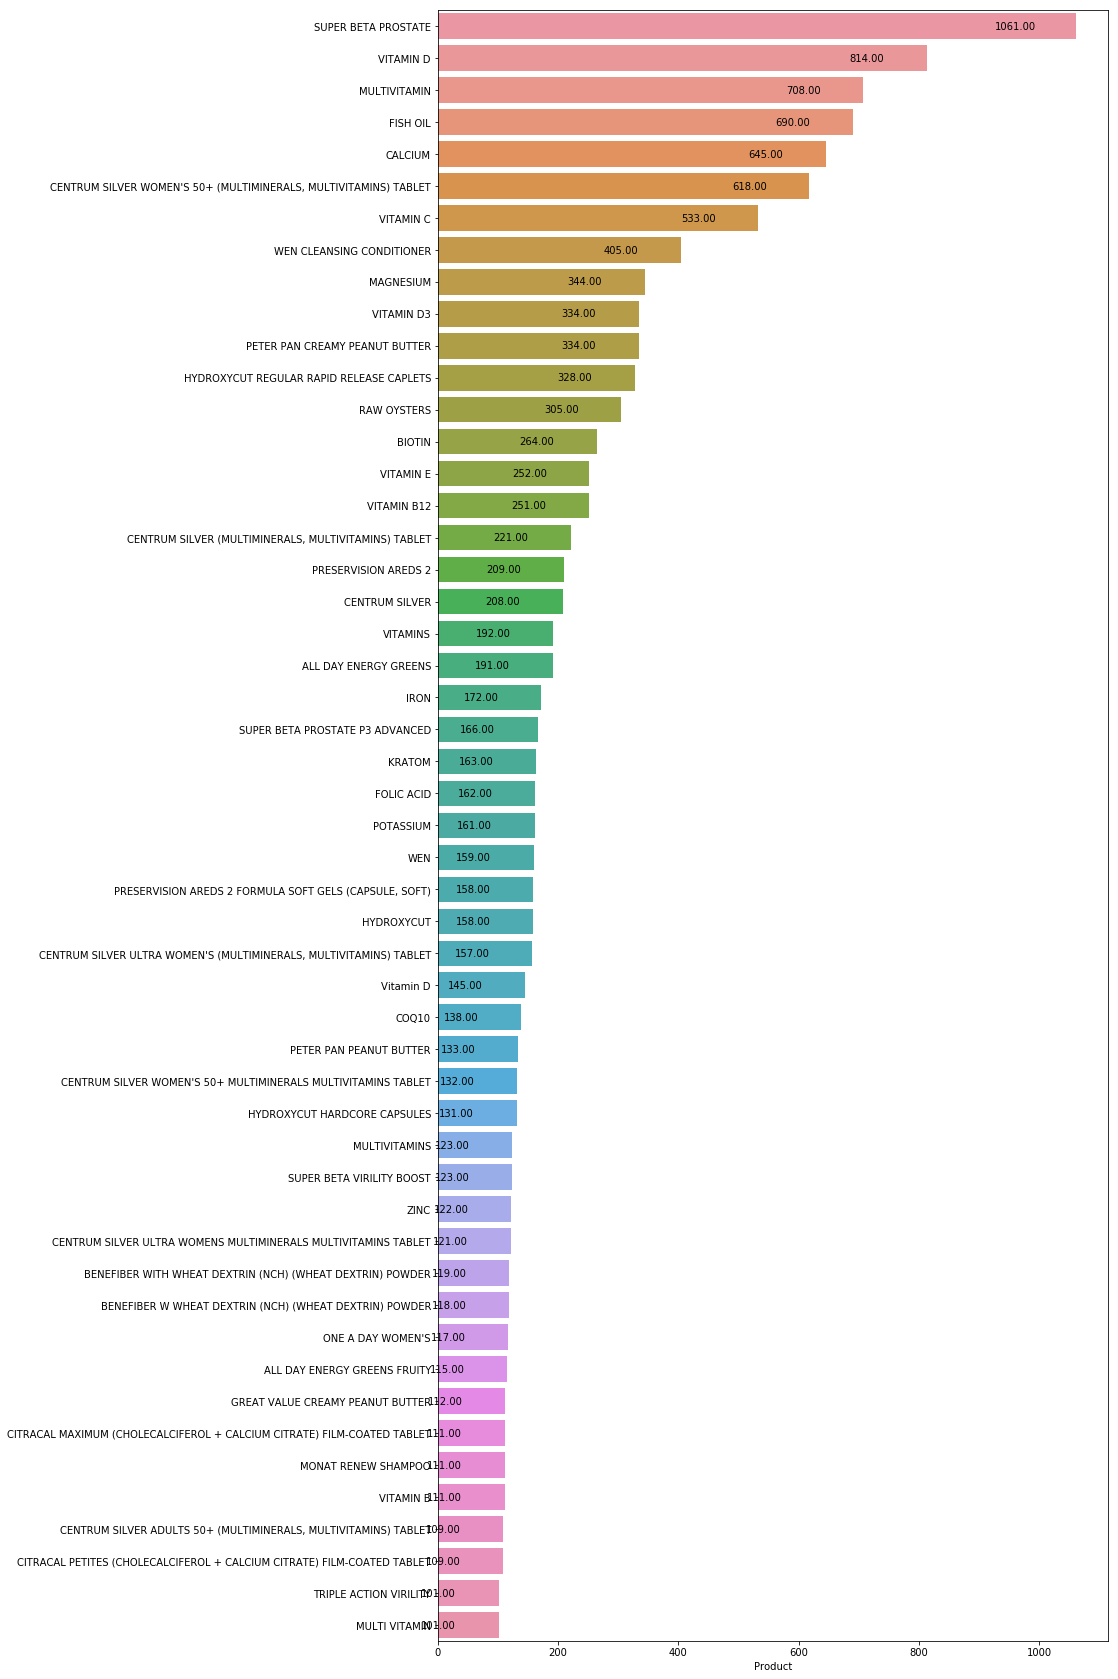

In [29]:
# annotation ref: https://stackoverflow.com/questions/42861049/horizontal-barplot-with-annotations

reported_prod_above_100 = adverse_events['Product'].value_counts()[adverse_events['Product'].value_counts() > 100]

plt.figure(figsize=(12, 30))
ax = sns.barplot(x = reported_prod_above_100, y = reported_prod_above_100.index)
for p in ax.patches:
    width = p.get_width()
    plt.text(p.get_width() - 100, p.get_y()+0.50*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center')

In [30]:
# ref: https://www.youtube.com/watch?v=yiO43TQ4xvc
# to display full width of columns

pd.set_option('display.max_colwidth', 2_000 )

## Analyzing dataframe that includes all categories for products

In [31]:
adverse_events_products_clean = adverse_events.groupby(['Product', 'Description'])['MedDRA Preferred Terms'].apply(', '.join).reset_index()

adverse_events_products_clean.head()

,Product,Description,MedDRA Preferred Terms
0,"""A LOT OF HEALTH PRODUCTS""",Vit/Min/Prot/Unconv Diet(Human/Animal),"VISUAL IMPAIRMENT, VISUAL ACUITY REDUCED, SPEECH DISORDER, NAUSEA, HEADACHE, GASTROINTESTINAL DISORDER, GAIT DISTURBANCE, FALL, DIZZINESS, DISTURBANCE IN ATTENTION, DISORIENTATION, BLINDNESS TRANSIENT, ASTHENIA"
1,"""ABSOLUTELY"" GLUTEN FREE FLATBREAD",Bakery Prod/Dough/Mix/Icing,"Muscle spasms, Heart rate irregular, Gastric haemorrhage, Food poisoning, Flushing, Faeces discoloured, Back pain, Abdominal pain upper"
2,"""MERITA"" OLD FASHIONED SANDWICH",Bakery Prod/Dough/Mix/Icing,DIARRHOEA
3,"""NITRO"" PROTEIN SUPPLEMENT",Vit/Min/Prot/Unconv Diet(Human/Animal),"PALPITATIONS, HYPERTENSION, BLOOD PRESSURE INCREASED"
4,"""NOW"" BRAND B-50 VITAMIN",Vit/Min/Prot/Unconv Diet(Human/Animal),ASTHMA


In [32]:
import re
adverse_events_products_clean['Product'] = adverse_events_products_clean.Product.map(lambda x: re.sub(r'[^\w\s]','',x).lower())

In [33]:
adverse_events_products_clean.set_index('Product', inplace = True)

In [34]:
adverse_events_products_clean.head()

,Description,MedDRA Preferred Terms
Product,,
a lot of health products,Vit/Min/Prot/Unconv Diet(Human/Animal),"VISUAL IMPAIRMENT, VISUAL ACUITY REDUCED, SPEECH DISORDER, NAUSEA, HEADACHE, GASTROINTESTINAL DISORDER, GAIT DISTURBANCE, FALL, DIZZINESS, DISTURBANCE IN ATTENTION, DISORIENTATION, BLINDNESS TRANSIENT, ASTHENIA"
absolutely gluten free flatbread,Bakery Prod/Dough/Mix/Icing,"Muscle spasms, Heart rate irregular, Gastric haemorrhage, Food poisoning, Flushing, Faeces discoloured, Back pain, Abdominal pain upper"
merita old fashioned sandwich,Bakery Prod/Dough/Mix/Icing,DIARRHOEA
nitro protein supplement,Vit/Min/Prot/Unconv Diet(Human/Animal),"PALPITATIONS, HYPERTENSION, BLOOD PRESSURE INCREASED"
now brand b50 vitamin,Vit/Min/Prot/Unconv Diet(Human/Animal),ASTHMA


In [35]:
# Top 5 products that are reported for adverse events
# These are a list of all the symptoms included in every report for the relative product
# Some of the already referenced side effects are listed here and it seems a common theme is nausea/vomiting.
    # These could be side effects for the vitamin itself, a bad combination with other vitamins, and/or an underlying
        # health issue that's not known.
        # ref: https://www.huffpost.com/entry/feel-sick-after-taking-vitamins_n_5a4d3911e4b06d1621bcc207

adverse_events_products_clean.loc[["super beta prostate", "vitamin d", "multivitamin", "fish oil", "calcium"]]


,Description,MedDRA Preferred Terms
Product,,
super beta prostate,Vit/Min/Prot/Unconv Diet(Human/Animal),"HEADACHE, HEART RATE INCREASED, HEADACHE, DYSPNOEA, MYOCARDIAL INFARCTION, RENAL PAIN, RENAL IMPAIRMENT, BLOOD PRESSURE INCREASED, VOMITING, URTICARIA, INFLUENZA LIKE ILLNESS, DYSPNOEA, BLOOD URINE PRESENT, INFECTION, THROMBOSIS, CEREBROVASCULAR ACCIDENT, MALAISE, HEART RATE INCREASED, CEREBROVASCULAR ACCIDENT, PROSTATOMEGALY, CHEST PAIN, ABNORMAL FAECES, LOSS OF CONSCIOUSNESS, FEELING ABNORMAL, SUICIDAL IDEATION, DYSPNOEA, HOSPITALISATION, BLOOD URINE PRESENT, HYPERTENSION, BLOOD PRESSURE FLUCTUATION, MYOCARDIAL INFARCTION, DYSPNOEA, ASTHENIA, DYSURIA, NAUSEA, DIZZINESS, PROSTATOMEGALY, OLIGURIA, BLOOD GLUCOSE INCREASED, BLOOD URINE PRESENT, BLOOD URINE PRESENT, PROSTATIC SPECIFIC ANTIGEN INCREASED, SOMNOLENCE, NAUSEA, GASTROINTESTINAL DISORDER, MYOCARDIAL INFARCTION, HEART RATE INCREASED, CARDIAC DISORDER, URINARY HESITATION, TESTICULAR SWELLING, VISUAL IMPAIRMENT, CEREBROVASCULAR ACCIDENT, FEELING ABNORMAL, BLOOD URINE PRESENT, PROSTATOMEGALY, RECTAL HAEMORRHAGE, BLOOD URINE PRESENT, HAEMORRHAGE, URINARY RETENTION, SCROTAL SWELLING, INFECTION, BLOOD URINE PRESENT, URINARY RETENTION, RASH GENERALISED, DYSPNOEA, DELUSIONAL PERCEPTION, CONSTIPATION, THROMBOSIS, MYOCARDIAL INFARCTION, MALAISE, BLOOD URINE PRESENT, TRANSIENT ISCHAEMIC ATTACK, URINARY TRACT DISORDER, OROPHARYNGEAL PAIN, GAIT DISTURBANCE, ASTHENIA, ACTIVITIES OF DAILY LIVING IMPAIRED, BLOOD URINE PRESENT, HEART RATE INCREASED, ATRIAL FIBRILLATION, HAEMORRHAGE, BLOOD PRESSURE INCREASED, ARRHYTHMIA, HEART RATE INCREASED, BLOOD PRESSURE INCREASED, BLOOD URINE PRESENT, HOSPITALISATION, HAEMORRHAGE, PROSTATOMEGALY, CONVULSION, CEREBROVASCULAR ACCIDENT, ANAL HAEMORRHAGE, LOSS OF CONSCIOUSNESS, DIZZINESS, BLOOD GLUCOSE INCREASED, HAEMATOCHEZIA, BLOOD URINE PRESENT, HYPERSENSITIVITY, BLOOD URINE PRESENT, SWELLING, PROSTATIC SPECIFIC ANTIGEN INCREASED, DYSURIA, BLOOD URINE PRESENT, FLUID RETENTION, EYE HAEMORRHAGE, BLOOD GLUCOSE FLUCTUATION, AMNESIA, URINARY TRACT INFECTION, HOSPITALISATION, HAEMATOCHEZIA, B..."
super beta prostate,Vit/Min/Prot/Unconv Diet(Human/Animal),Blood urine present
vitamin d,Vit/Min/Prot/Unconv Diet(Human/Animal),"DIZZINESS, DIZZINESS, LUNG NEOPLASM MALIGNANT, VOMITING, PRURITUS, JAUNDICE, HEPATIC ENZYME INCREASED, CHOLELITHIASIS OBSTRUCTIVE, URTICARIA, URTICARIA, TONGUE OEDEMA, THROAT TIGHTNESS, RASH, OROPHARYNGEAL SWELLING, LARYNGOSPASM, ERYTHEMA, ERYTHEMA, DYSPNOEA, UTERINE CANCER, URINARY INCONTINENCE, OSTEOPENIA, FOREIGN BODY TRAUMA, FOREIGN BODY TRAUMA, CHOKING, BREAST CANCER, SWOLLEN TONGUE, SWELLING, HYPERSENSITIVITY, PRURITUS, ERYTHEMA, VOMITING, FOREIGN BODY TRAUMA, DYSPNOEA, DYSPHAGIA, CHOKING, SELF-INDUCED VOMITING, REMOVAL OF FOREIGN BODY FROM THROAT, REMOVAL OF FOREIGN BODY FROM THROAT, DYSPNOEA, DYSPHASIA, CHOKING, PAIN, HYPOACUSIS, EAR PAIN, DEAFNESS, SWELLING, FACE OEDEMA, FOREIGN BODY TRAUMA, DYSPNOEA, DYSPHAGIA, THROAT TIGHTNESS, MIGRAINE, HYPERSENSITIVITY, DIARRHOEA, ASTHMA, ABDOMINAL PAIN UPPER, PETECHIAE, HAEMORRHAGE, HAEMATOCHEZIA, FAECES DISCOLOURED, HYPERTENSION, SYNCOPE, STOMACH DISCOMFORT, PNEUMONIA, NIGHTMARE, INSOMNIA, FLATULENCE, ERUCTATION, ABDOMINAL PAIN, ABDOMINAL DISTENSION, ABDOMINAL DISCOMFORT, POISONING, WEIGHT INCREASED, WEIGHT INCREASED, VENTRICULAR EXTRASYSTOLES, PALPITATIONS, OEDEMA PERIPHERAL, OEDEMA PERIPHERAL, HYPERTENSION, HEART RATE INCREASED, FLUID RETENTION, FLUID RETENTION, CARDIAC FLUTTER, ATRIAL FIBRILLATION, RENAL DISORDER, CARDIAC FAILURE CONGESTIVE, WEIGHT INCREASED, VENTRICULAR EXTRASYSTOLES, OEDEMA PERIPHERAL, FLUID RETENTION, CARDIAC FLUTTER, ATRIAL FIBRILLATION, REMOVAL OF FOREIGN BODY FROM THROAT, DYSPNOEA, DYSPHAGIA, CHOKING, FLUSHING, FEELING HOT, ERYTHEMA, BURNING SENSATION, ADVERSE EVENT, URINARY HESITATION, NIPPLE DISORDER, INSOMNIA, HYPERTENSION, HEART INJURY, CONFUSIONAL STATE, CARDIOVASCULAR DISORDER, NEUROPATHY PERIPHERAL, HYPOAESTHESIA, SOMNOLENCE, NAUSEA, LIVER FUNCTION TEST 

## Creating subsets for different categories

- There will be a total of 3 models
    - Cosmetics: 5259 products
    - Food: 20842 products
    - Supplements: 24035 products
    
- This will allow users to be able to get products with similar reactions as well as under similar categories

In [36]:
# Category: cosmetics

adverse_events_cosmetics = adverse_events[adverse_events['Description'] == ' Cosmetics']

In [37]:
adverse_events_cosmetics.shape

(8298, 12)

In [38]:
# Categories: vitamins and supplements

adverse_events_supplements = adverse_events[(adverse_events['Description'] == ' Vit/Min/Prot/Unconv Diet(Human/Animal)') |
                                            (adverse_events['Description'] == 'G Medical Foods, N.E.C.')]


In [39]:
adverse_events_supplements.shape

(55231, 12)

In [40]:
# Category: Any food related items (including infant formula)

adverse_events_food = adverse_events[(adverse_events['Description'] != ' Vit/Min/Prot/Unconv Diet(Human/Animal)') &
                                    (adverse_events['Description'] != 'G Medical Foods, N.E.C.') &
                                    (adverse_events['Description'] != ' Cosmetics')]

In [41]:
# Using regex to remove punctuation from Product names and making all text lowercase

import re
adverse_events_cosmetics['Product'] = adverse_events_cosmetics.Product.map(lambda x: re.sub(r'[^\w\s]','',x).lower())
adverse_events_supplements['Product'] = adverse_events_supplements.Product.map(lambda x: re.sub(r'[^\w\s]','',x).lower())
adverse_events_food['Product'] = adverse_events_food.Product.map(lambda x: re.sub(r'[^\w\s]','',x).lower())

In [42]:
# Creating dataframes that combine all products with the same product name and description into one row

adverse_events_cosmetics = adverse_events_cosmetics.groupby(['Product', 'Description'])['MedDRA Preferred Terms'].apply(', '.join).reset_index()
adverse_events_supplements = adverse_events_supplements.groupby(['Product', 'Description'])['MedDRA Preferred Terms'].apply(', '.join).reset_index()
adverse_events_food = adverse_events_food.groupby(['Product', 'Description'])['MedDRA Preferred Terms'].apply(', '.join).reset_index()


In [43]:
# Using product name as the index for recommender system

adverse_events_cosmetics.set_index('Product', inplace = True)
adverse_events_supplements.set_index('Product', inplace = True)
adverse_events_food.set_index('Product', inplace = True)

In [44]:
adverse_events_cosmetics.to_csv('./datasets/adverse_events_cosmetics.csv')

In [45]:
adverse_events_food.to_csv('./datasets/adverse_events_food.csv')

In [46]:
adverse_events_supplements.to_csv('./datasets/adverse_events_supplements.csv')

In [47]:
adverse_events_cosmetics.shape

(5259, 2)

In [48]:
adverse_events_food.shape

(20842, 2)

In [49]:
adverse_events_supplements.shape

(24035, 2)

## CountVectorizer matrices and cosine similiarities for all 3 categories

In [50]:
# ref: https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243
cv = CountVectorizer()
cv_matrix_cosmetics = cv.fit_transform(adverse_events_cosmetics['MedDRA Preferred Terms'])

cosine_sim_cosmetics = cosine_similarity(cv_matrix_cosmetics, cv_matrix_cosmetics)

In [51]:
cv_matrix_supplements = cv.fit_transform(adverse_events_supplements['MedDRA Preferred Terms'])

cosine_sim_supplements = cosine_similarity(cv_matrix_supplements, cv_matrix_supplements)

In [52]:
cv_matrix_food = cv.fit_transform(adverse_events_food['MedDRA Preferred Terms'])

cosine_sim_food = cosine_similarity(cv_matrix_food, cv_matrix_food)

## Recommender system that will be able to take in different datasets

In [53]:
# ref: https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243

# function that will take in a product and output said product along with 10 other products that are most related
    #  or reference similar symptoms
def beware_recommendations(df, product, cosine_sim):

    indices = pd.Series(df.index)
    beware_of_products = []
    
    # pulls index of the product that is inputted into this function
    # prod_index = indices[indices == product].index[0] >>> this is if I want function to take exact product name
    try:
        prod_index = indices[indices.str.contains(product)].index[0]

        # want df output to also include the inputted product for comparison
        beware_of_products.append(product)

        # puts similarity scores in descending order
        similarity_scores = pd.Series(cosine_sim[prod_index]).sort_values(ascending = False)

        # pulls index of 10 products that have similar reported adverse events
        similar_10_prod = list(similarity_scores.iloc[1:11].index)

        # adding list of products to beware_of_products list
        for i in similar_10_prod:
            beware_of_products.append(list(df.index)[i])

        # want to output a dataframe that will show the products with associated descriptions and details of adverse events  
        return df.loc[beware_of_products]
    
    except:
        print("Great news! This product hasn't been reported to the FDA as causing negative side effects.")



### Cosmetics result for testing system using keywords vs. exact product name

- Results are most similar based on below tests. 
- This dataframe is the smallest of the 3 categories
- Similar results may be due to the more distinct key terms in the product names

In [54]:
adverse_events_cosmetics.index

Index(['100 best bentonite clay 100 pounds',
       '100 daily hydration milk mask w coconut milk  acacia senegal',
       '100 pure bentonite fine powder', '100 pure best bentonite clay',
       '100 pure best benzonite clay',
       '100 virgin coconut oil hydration milk mask', '24k antiaging eye serum',
       '24k dark circle eye solution', '24k dmae deep wrinkle',
       '24k moisturizing day cream',
       ...
       'zauders professional face makeup', 'zeda tanning mystify',
       'zinc oxide powder usp non nano 1',
       'zoto agebeautiful demi permanent 6 volume creme developer',
       'zoto agebeautiful permanent creme lightener',
       'zotos agebeautiful hla high lift ash blonde permenent liqui creme haircolor',
       'zotos feels so lively regular perm', 'zuri natural sheer satin finish',
       'zury french deep weave 10 inch human hair extensions color 1 b',
       'zury french deep weave fdw 10  color 1b'],
      dtype='object', name='Product', length=5259)

In [55]:
# searching brand from 'zoto agebeautiful permanent creme lightener'

beware_recommendations(adverse_events_cosmetics, 'zoto', cosine_sim_cosmetics)

,Description,MedDRA Preferred Terms
Product,,
zoto,NaN,NaN
ion color brilliance intensive shine 00 clear demi permanent hair color,Cosmetics,"Swelling, Deformity"
zotos agebeautiful hla high lift ash blonde permenent liqui creme haircolor,Cosmetics,"Swelling, Deformity"
zoto agebeautiful permanent creme lightener,Cosmetics,"Swelling, Deformity"
zoto agebeautiful demi permanent 6 volume creme developer,Cosmetics,"Swelling, Deformity"
walgreens natures finest alphahydroxy skin lotion,Cosmetics,SWELLING
loreal colour riche eyeshadow,Cosmetics,SWELLING
superior preference hair coloring,Cosmetics,SWELLING
premier pigments red tattoo permanent makeup,Cosmetics,SWELLING


In [56]:
# searching exact product name

beware_recommendations(adverse_events_cosmetics, 'zoto agebeautiful permanent creme lightener', cosine_sim_cosmetics)

,Description,MedDRA Preferred Terms
Product,,
zoto agebeautiful permanent creme lightener,Cosmetics,"Swelling, Deformity"
ion color brilliance intensive shine 00 clear demi permanent hair color,Cosmetics,"Swelling, Deformity"
zotos agebeautiful hla high lift ash blonde permenent liqui creme haircolor,Cosmetics,"Swelling, Deformity"
zoto agebeautiful permanent creme lightener,Cosmetics,"Swelling, Deformity"
zoto agebeautiful demi permanent 6 volume creme developer,Cosmetics,"Swelling, Deformity"
walgreens natures finest alphahydroxy skin lotion,Cosmetics,SWELLING
loreal colour riche eyeshadow,Cosmetics,SWELLING
superior preference hair coloring,Cosmetics,SWELLING
premier pigments red tattoo permanent makeup,Cosmetics,SWELLING


In [57]:
# search for keyword from '100 best bentonite clay 100 pounds'

beware_recommendations(adverse_events_cosmetics, 'clay', cosine_sim_cosmetics)

,Description,MedDRA Preferred Terms
Product,,
clay,NaN,NaN
garnier fructis sleek and shine shampoo,Cosmetics,"Urticaria, Rash erythematous, Pruritus, Hypersensitivity"
garnier fructis sleek and shine conditioner,Cosmetics,"Urticaria, Rash erythematous, Pruritus, Hypersensitivity"
st ives body lotion,Cosmetics,"RASH, PRURITUS, HYPERSENSITIVITY"
henna powder and essential oil,Cosmetics,"RASH, PRURITUS, HYPERSENSITIVITY"
lubriderm mens 3 in 1 lotion fragrance free dermatological products lotion,Cosmetics,"RASH, PRURITUS, HYPERSENSITIVITY"
redken permanent color gels,Cosmetics,"Rash, Pruritus, Hypersensitivity"
carmex everyday hydrating lotion,Cosmetics,"RASH, PRURITUS, HYPERSENSITIVITY"
aveeno baby,Cosmetics,"RASH, PRURITUS, HYPERSENSITIVITY"


In [58]:
# search for exact product name

beware_recommendations(adverse_events_cosmetics, '100 best bentonite clay 100 pounds', cosine_sim_cosmetics)

,Description,MedDRA Preferred Terms
Product,,
100 best bentonite clay 100 pounds,Cosmetics,"RASH ERYTHEMATOUS, PRURITUS, HYPERSENSITIVITY"
garnier fructis sleek and shine shampoo,Cosmetics,"Urticaria, Rash erythematous, Pruritus, Hypersensitivity"
garnier fructis sleek and shine conditioner,Cosmetics,"Urticaria, Rash erythematous, Pruritus, Hypersensitivity"
st ives body lotion,Cosmetics,"RASH, PRURITUS, HYPERSENSITIVITY"
henna powder and essential oil,Cosmetics,"RASH, PRURITUS, HYPERSENSITIVITY"
lubriderm mens 3 in 1 lotion fragrance free dermatological products lotion,Cosmetics,"RASH, PRURITUS, HYPERSENSITIVITY"
redken permanent color gels,Cosmetics,"Rash, Pruritus, Hypersensitivity"
carmex everyday hydrating lotion,Cosmetics,"RASH, PRURITUS, HYPERSENSITIVITY"
aveeno baby,Cosmetics,"RASH, PRURITUS, HYPERSENSITIVITY"


### Supplements result for testing system using keywords vs. exact product name

- Two different results, as there happened to be results for the general vitamin b product, which was used as the keyword search. Due to this being more of a general product, there were more symptoms listed, compared to the one symtpom that was referenced for the specific vitamin b6 product
- Inconsistency is due to reports being entered manually.
    - Consumer could have used a generic brand for the supplement, or the one that submitted report didn't find a need to be specific about the name of the supplement
    - This is an issue that can affect all 3 categories

In [59]:
adverse_events_supplements.index

Index(['02 gold', '1  mr', '1 a day adult vita crave energy',
       '1 a day vitamin', '1 day diet pill',
       '1 gram of calcium with 800 units of vitamin d', '1 mr',
       '1 phenemine like adipex 375 rapid quck fast weight loss strong best diet pills',
       '1 tryptophan', '10 billion cell probiotic',
       ...
       'zygest dietary supplement', 'zygest super papaya plus chewable wafers',
       'zymessence', 'zymex', 'zymex  standard process', 'zyrexin',
       'zyrexin male enhancement', 'zyto scan', 'zytropin', 'zzzquil'],
      dtype='object', name='Product', length=24035)

In [60]:
# search keyword from 'puritans pride vitamin b6'

beware_recommendations(adverse_events_supplements, 'vitamin b', cosine_sim_supplements)

,Description,MedDRA Preferred Terms
Product,,
vitamin b,Vit/Min/Prot/Unconv Diet(Human/Animal),"DIZZINESS, DIZZINESS, WEIGHT DECREASED, VOMITING, NAUSEA, DIARRHOEA, HAEMORRHOIDS, HAEMATOCHEZIA, CONSTIPATION, IMMUNE SYSTEM DISORDER, HAEMOGLOBIN DECREASED, CHEST PAIN, ANAEMIA, DYSPNOEA, DYSPHAGIA, CHOKING, TIBIA FRACTURE, SURGERY, OVERDOSE, JOINT CREPITATION, IMPAIRED HEALING, FALL, SPEECH DISORDER, PERSONALITY DISORDER, MEMORY IMPAIRMENT, HOSTILITY, FEAR, AMNESIA, AGGRESSION, ABNORMAL BEHAVIOUR, VISUAL IMPAIRMENT, PUPIL FIXED, PHOTOPHOBIA, OCULAR HYPERAEMIA, NAIL INFECTION, HERPES ZOSTER, HEADACHE, EYELID INFECTION, EYE SWELLING, CONJUNCTIVITIS, CONFUSIONAL STATE, BLOOD PRESSURE INCREASED, BLOOD ARSENIC INCREASED, PHARYNGEAL HAEMORRHAGE, DYSPHAGIA, CHOKING, MYOCARDIAL INFARCTION, LOSS OF CONSCIOUSNESS, BACK PAIN, ASTHENIA, PRODUCTIVE COUGH, HAEMOPTYSIS, LOSS OF CONSCIOUSNESS, ASTHENIA, VISUAL ACUITY REDUCED, VISION BLURRED, CATARACT, HYPERSENSITIVITY, FEELING COLD, CHILLS, JAUNDICE, CONSTIPATION, ASPARTATE AMINOTRANSFERASE INCREASED, ALANINE AMINOTRANSFERASE INCREASED, ABDOMINAL PAIN, PAIN, FALL, DYSPHAGIA, CHOKING, CHEST PAIN, BACK PAIN, FOREIGN BODY TRAUMA, DYSPHAGIA, NAUSEA, DIZZINESS, SWOLLEN TONGUE, PRURITUS, HYPERTENSION, HYPERSENSITIVITY, DYSPNOEA, BURNING SENSATION, SWELLING, PERICARDIAL EFFUSION, OEDEMA PERIPHERAL, BLOOD PRESSURE INCREASED, RECTAL CANCER, CONSTIPATION, COLON OPERATION, DYSPHAGIA, CHOKING, RASH, PRURITUS, LIVER FUNCTION TEST ABNORMAL, JAUNDICE, FATIGUE, CHROMATURIA, TYPE 2 DIABETES MELLITUS, SKIN LESION, LIVER INJURY, LIVER FUNCTION TEST ABNORMAL, HEPATITIS, EPISTAXIS, THYROID FUNCTION TEST ABNORMAL, PALPITATIONS, HYPERTHYROIDISM, HAEMATOCHEZIA, GASTROENTERITIS, OBSTRUCTIVE AIRWAYS DISORDER, FOREIGN BODY TRAUMA, CHOKING, HEART RATE INCREASED, FOREIGN BODY TRAUMA, DYSPHAGIA, LOSS OF CONSCIOUSNESS, ERYTHEMA, DYSPNOEA, DEPRESSION, CHEST DISCOMFORT, PARAESTHESIA, FURUNCLE, CYST, CARBUNCLE, TRANSIENT ISCHAEMIC ATTACK, RASH, PRURITUS, HYPOAESTHESIA, TREMOR, LOSS OF CONSCIOUSNESS, CONVULSION, PRURITUS, NAUSEA, MALAISE, JAUNDICE, FATIGUE, C..."
zone all natural peanut butter and chocolate nutrition bars,Vit/Min/Prot/Unconv Diet(Human/Animal),"VOMITING, FEELING OF BODY TEMPERATURE CHANGE, DIARRHOEA"
unknown dietary supplements,Vit/Min/Prot/Unconv Diet(Human/Animal),"SALMONELLOSIS, NAUSEA, MYALGIA, HEADACHE, HAEMATOCHEZIA, FEELING OF BODY TEMPERATURE CHANGE, DIARRHOEA HAEMORRHAGIC, BODY TEMPERATURE INCREASED, ARTHRALGIA, ABDOMINAL PAIN"
lipozene amorphophallus konjac 1500mg,Vit/Min/Prot/Unconv Diet(Human/Animal),"RECTAL HAEMORRHAGE, NAUSEA, HEADACHE, HAEMATOCHEZIA, FEELING OF BODY TEMPERATURE CHANGE, CONSTIPATION, BODY TEMPERATURE INCREASED, ABDOMINAL PAIN UPPER, ABDOMINAL PAIN, ABDOMINAL DISTENSION"
attain nutrition bars chocolate peanut butter,Vit/Min/Prot/Unconv Diet(Human/Animal),"VOMITING, NAUSEA, FEELING OF BODY TEMPERATURE CHANGE, DIARRHOEA, CHILLS, BODY TEMPERATURE INCREASED, DIARRHOEA"
mcneil nutritionals lactaid fast act lactase enzyme 9000 pcc lactose units capsule,Vit/Min/Prot/Unconv Diet(Human/Animal),"VOMITING, NAUSEA, HYPERSENSITIVITY, HEADACHE, FLUSHING, FEELING OF BODY TEMPERATURE CHANGE, ERYTHEMA, ABDOMINAL PAIN"
superior metabolic technologies smt uprizing 20,Vit/Min/Prot/Unconv Diet(Human/Animal),"NAUSEA, NAUSEA, HAEMATURIA, BACK PAIN, ABDOMINAL PAIN, MOOD SWINGS, FEELING OF BODY TEMPERATURE CHANGE, CONSTIPATION, BODY TEMPERATURE INCREASED, BACK PAIN, ANXIETY, ABDOMINAL PAIN"
vitality powder,Vit/Min/Prot/Unconv Diet(Human/Animal),"Pruritus, Hypersensitivity, Feeling of body temperature change"
vitamin shoppe calcium carbonate with vit d soft gels,Vit/Min/Prot/Unconv Diet(Human/Animal),"NAUSEA, MALAISE, FEELING OF BODY TEMPERATURE CHANGE"


In [61]:
# search exact product name

beware_recommendations(adverse_events_supplements, 'puritans pride vitamin b6', cosine_sim_supplements)

,Description,MedDRA Preferred Terms
Product,,
puritans pride vitamin b6,Vit/Min/Prot/Unconv Diet(Human/Animal),CHEST PAIN
puritans pride vitamin b6,Vit/Min/Prot/Unconv Diet(Human/Animal),CHEST PAIN
swanson ultra swanson ultra semsc selenium,Vit/Min/Prot/Unconv Diet(Human/Animal),Chest pain
puritans pride resveratrol 50 mg rapid release softgels,Vit/Min/Prot/Unconv Diet(Human/Animal),CHEST PAIN
puritans pride turmeric 400 mg capsules,Vit/Min/Prot/Unconv Diet(Human/Animal),CHEST PAIN
natures bounty echinacia 400 mg,Vit/Min/Prot/Unconv Diet(Human/Animal),CHEST PAIN
spring valley three per day enteric coated fish oil 1000 mg 300 mg omega3 softgels,Vit/Min/Prot/Unconv Diet(Human/Animal),CHEST PAIN
5hydroxytryptophan,Vit/Min/Prot/Unconv Diet(Human/Animal),CHEST PAIN
swanson ultra msm,Vit/Min/Prot/Unconv Diet(Human/Animal),Chest pain


In [62]:
# A lot of symptoms for Super Beta Prostate product were blood related, which resulted in other products with
    # blood related symptoms.

beware_recommendations(adverse_events_supplements, 'super beta prostate', cosine_sim_supplements)

,Description,MedDRA Preferred Terms
Product,,
super beta prostate,Vit/Min/Prot/Unconv Diet(Human/Animal),"HEADACHE, HEART RATE INCREASED, HEADACHE, DYSPNOEA, MYOCARDIAL INFARCTION, RENAL PAIN, RENAL IMPAIRMENT, BLOOD PRESSURE INCREASED, VOMITING, URTICARIA, INFLUENZA LIKE ILLNESS, DYSPNOEA, BLOOD URINE PRESENT, INFECTION, THROMBOSIS, CEREBROVASCULAR ACCIDENT, MALAISE, HEART RATE INCREASED, CEREBROVASCULAR ACCIDENT, PROSTATOMEGALY, CHEST PAIN, ABNORMAL FAECES, LOSS OF CONSCIOUSNESS, FEELING ABNORMAL, SUICIDAL IDEATION, DYSPNOEA, HOSPITALISATION, BLOOD URINE PRESENT, HYPERTENSION, BLOOD PRESSURE FLUCTUATION, MYOCARDIAL INFARCTION, DYSPNOEA, ASTHENIA, DYSURIA, NAUSEA, DIZZINESS, PROSTATOMEGALY, OLIGURIA, BLOOD GLUCOSE INCREASED, BLOOD URINE PRESENT, BLOOD URINE PRESENT, PROSTATIC SPECIFIC ANTIGEN INCREASED, SOMNOLENCE, NAUSEA, GASTROINTESTINAL DISORDER, MYOCARDIAL INFARCTION, HEART RATE INCREASED, CARDIAC DISORDER, URINARY HESITATION, TESTICULAR SWELLING, VISUAL IMPAIRMENT, CEREBROVASCULAR ACCIDENT, FEELING ABNORMAL, BLOOD URINE PRESENT, PROSTATOMEGALY, RECTAL HAEMORRHAGE, BLOOD URINE PRESENT, HAEMORRHAGE, URINARY RETENTION, SCROTAL SWELLING, INFECTION, BLOOD URINE PRESENT, URINARY RETENTION, RASH GENERALISED, DYSPNOEA, DELUSIONAL PERCEPTION, CONSTIPATION, THROMBOSIS, MYOCARDIAL INFARCTION, MALAISE, BLOOD URINE PRESENT, TRANSIENT ISCHAEMIC ATTACK, URINARY TRACT DISORDER, OROPHARYNGEAL PAIN, GAIT DISTURBANCE, ASTHENIA, ACTIVITIES OF DAILY LIVING IMPAIRED, BLOOD URINE PRESENT, HEART RATE INCREASED, ATRIAL FIBRILLATION, HAEMORRHAGE, BLOOD PRESSURE INCREASED, ARRHYTHMIA, HEART RATE INCREASED, BLOOD PRESSURE INCREASED, BLOOD URINE PRESENT, HOSPITALISATION, HAEMORRHAGE, PROSTATOMEGALY, CONVULSION, CEREBROVASCULAR ACCIDENT, ANAL HAEMORRHAGE, LOSS OF CONSCIOUSNESS, DIZZINESS, BLOOD GLUCOSE INCREASED, HAEMATOCHEZIA, BLOOD URINE PRESENT, HYPERSENSITIVITY, BLOOD URINE PRESENT, SWELLING, PROSTATIC SPECIFIC ANTIGEN INCREASED, DYSURIA, BLOOD URINE PRESENT, FLUID RETENTION, EYE HAEMORRHAGE, BLOOD GLUCOSE FLUCTUATION, AMNESIA, URINARY TRACT INFECTION, HOSPITALISATION, HAEMATOCHEZIA, B..."
nac marketing triple action virility,Vit/Min/Prot/Unconv Diet(Human/Animal),"BLOOD PRESSURE INCREASED, BLOOD GLUCOSE INCREASED, NAUSEA, BODY TEMPERATURE INCREASED, BLOOD PRESSURE INCREASED, BACTERIAL INFECTION"
swp016 swanson mega yohimbe extract 750mg,Vit/Min/Prot/Unconv Diet(Human/Animal),"INFECTION, CHEST PAIN, BODY TEMPERATURE INCREASED, BLOOD PRESSURE INCREASED"
vit c ascorbic acid,Vit/Min/Prot/Unconv Diet(Human/Animal),"NAUSEA, DIZZINESS, CONDITION AGGRAVATED, BLOOD PRESSURE INCREASED, BLOOD PRESSURE INCREASED, BLOOD GLUCOSE INCREASED, ASTHENIA, SKIN EXFOLIATION, FUNGAL INFECTION"
garlic allium sativum capsule,Vit/Min/Prot/Unconv Diet(Human/Animal),"NAUSEA, DIZZINESS, CONDITION AGGRAVATED, BLOOD PRESSURE INCREASED, BLOOD PRESSURE INCREASED, BLOOD GLUCOSE INCREASED, ASTHENIA"
centrum cardio multivitamin,Vit/Min/Prot/Unconv Diet(Human/Animal),"CONDITION AGGRAVATED, BLOOD PRESSURE INCREASED, BLOOD PRESSURE INCREASED"
all new forskolin ultra diet,Vit/Min/Prot/Unconv Diet(Human/Animal),"GLYCOSYLATED HAEMOGLOBIN INCREASED, DYSPNOEA, BLOOD PRESSURE INCREASED, BLOOD PRESSURE INCREASED, BLOOD GLUCOSE INCREASED"
sundown naturals magnesium,Vit/Min/Prot/Unconv Diet(Human/Animal),Blood pressure increased
bromilene,Vit/Min/Prot/Unconv Diet(Human/Animal),BLOOD PRESSURE INCREASED


### Food result for testing system using keywords vs. exact product name

- Full product name is 'organic baby spinach'. Despite not recognizing the exact index for the product mostly related, it was able to come close in terms of the symptoms consumers were experiencing from different products

In [63]:
# Search using keywords

beware_recommendations(adverse_events_food, 'organic spinach', cosine_sim_food)

,Description,MedDRA Preferred Terms
Product,,
organic spinach,NaN,NaN
jin ramen packaged noodles spicy,Macaroni/Noodle Prod,"DIARRHOEA, ABDOMINAL PAIN, DIARRHOEA, ABDOMINAL PAIN, DIARRHOEA, ABDOMINAL PAIN UPPER"
grits,Cereal Prep/Breakfast Food,"DIARRHOEA, ABDOMINAL PAIN"
grits,Whole Grain/Milled Grain Prod/Starch,BURNING SENSATION
polar anchovies flat fillet anchovies,Fishery/Seafood Prod,"DIARRHOEA, ABDOMINAL PAIN"
polar beverages tonic water,Soft Drink/Water,"DIARRHOEA, ABDOMINAL PAIN"
josephs lite cookies chocolatechip cookies,Bakery Prod/Dough/Mix/Icing,"DIARRHOEA, ABDOMINAL PAIN"
evian bottled water,Soft Drink/Water,"DIARRHOEA, ABDOMINAL PAIN"
berry boss inc fresh strawberries,Fruit/Fruit Prod,"DIARRHOEA, ABDOMINAL PAIN"


In [64]:
# Search using exact product name

beware_recommendations(adverse_events_food, 'organic baby spinach', cosine_sim_food)

,Description,MedDRA Preferred Terms
Product,,
organic baby spinach,Vegetables/Vegetable Products,"Vomiting, Diarrhoea"
hostess cherry pie,Bakery Prod/Dough/Mix/Icing,"NAUSEA, FEELING OF BODY TEMPERATURE CHANGE, DIARRHOEA, CHILLS, APPETITE DISORDER, ABDOMINAL PAIN UPPER, ABDOMINAL PAIN"
maranatha raw almond butter,Nuts/Edible Seed,"MALAISE, LETHARGY, FEELING OF BODY TEMPERATURE CHANGE, DIARRHOEA, DECREASED APPETITE, APPETITE DISORDER, ABDOMINAL PAIN, NAUSEA, FEELING OF BODY TEMPERATURE CHANGE, DIARRHOEA, APPETITE DISORDER, ABDOMINAL PAIN, ABDOMINAL PAIN"
olivias organics 50 50 blend baby spinach spring salad mix,Vegetables/Vegetable Products,"PYREXIA, NAUSEA, MALAISE, FEELING OF BODY TEMPERATURE CHANGE, FATIGUE, DIARRHOEA, ABDOMINAL PAIN UPPER, ABDOMINAL PAIN, ABDOMINAL DISTENSION"
great value 2 lowfat milk,Milk/Butter/Dried Milk Prod,"NAUSEA, HYPERHIDROSIS, FLATULENCE, FEELING OF BODY TEMPERATURE CHANGE, ABDOMINAL PAIN UPPER, ABDOMINAL PAIN"
stouffers frozen vegetable lasagna,Mult Food Dinner/Grav/Sauce/Special,"NAUSEA, FEELING OF BODY TEMPERATURE CHANGE, DIARRHOEA, CHILLS, ABDOMINAL PAIN UPPER, ABDOMINAL PAIN, NAUSEA, FEELING OF BODY TEMPERATURE CHANGE, DIARRHOEA, CHILLS, ABDOMINAL PAIN UPPER, ABDOMINAL PAIN"
nutrisystem pasta fagioli soup,Soup,"VOMITING, NAUSEA, FEELING OF BODY TEMPERATURE CHANGE, DIARRHOEA, ABDOMINAL PAIN UPPER, ABDOMINAL PAIN"
kirkland signature pecan halves,Nuts/Edible Seed,"DIARRHOEA, ABDOMINAL PAIN, VOMITING, NAUSEA, FEELING OF BODY TEMPERATURE CHANGE, DIARRHOEA, CHILLS, ABDOMINAL PAIN UPPER, ABDOMINAL PAIN"
kroger dry roasted unsalted peanuts,Nuts/Edible Seed,"NAUSEA, FEELING OF BODY TEMPERATURE CHANGE, DIARRHOEA, CHILLS, ABDOMINAL PAIN, ABDOMINAL DISTENSION"


In [65]:
beware_recommendations(adverse_events_food, 'o organic baby spinach', cosine_sim_food)

,Description,MedDRA Preferred Terms
Product,,
o organic baby spinach,Vegetables/Vegetable Products,"VOMITING, NAUSEA, MALAISE"
nestlle coffee mate creamer,Filled Milk/Imit Milk Prod,"VOMITING, NAUSEA, MALAISE"
krusteaz buttermilk pancakes,Cereal Prep/Breakfast Food,"VOMITING, NAUSEA, MALAISE"
goodies by nature dried mango,Fruit/Fruit Prod,"VOMITING, NAUSEA, MALAISE"
ground wheat bread,Bakery Prod/Dough/Mix/Icing,"VOMITING, NAUSEA, MALAISE"
tastykake glazed honey buns,Bakery Prod/Dough/Mix/Icing,"VOMITING, NAUSEA, MALAISE"
arizona brand no carb peach green iced tea,Coffee/Tea,"VOMITING, NAUSEA, MALAISE"
nut bar company inc nut bar nut tray,Choc/Cocoa Prod,"VOMITING, NAUSEA, MALAISE"
oreo lemon flavored oreo cookie,Bakery Prod/Dough/Mix/Icing,"VOMITING, NAUSEA, MALAISE"


## Research
### Recall announcements under each category

- Randomly selected and researched one product for each category

In [66]:
# ref: https://www.geeksforgeeks.org/convert-the-column-type-from-string-to-datetime-format-in-pandas-dataframe/
# setting these columns to datetime format will allow user to pull events that were reported within a time period

adverse_events['CAERS Created Date'] = pd.to_datetime(adverse_events['CAERS Created Date']) 
adverse_events['Date of Event'] = pd.to_datetime(adverse_events['Date of Event'])

In [67]:
adverse_events.to_csv('./datasets/adverse_events_2.csv', index = False)

### Cosmetics:

- Best Bentonite Clay: 
    - Product meant for removing impurities on the skin, some will ingest to remove toxins
        - ref: https://www.medicalnewstoday.com/articles/325241.php
    - [3/23/16 - FDA warning to stop using product](https://www.fda.gov/drugs/drug-safety-and-availability/fda-warns-consumers-not-use-best-bentonite-clay)
    - Adverse events were reported between March 2016 to July 2017, but occurred between Dec 2015 and July 2017 
         - About 11 cases
    - Lead poisoning risk
        - FDA has found high levels of lead, but has not found confirmed cases. This came out 3/23/16, and there were two reported cases for metal poisoning along with other symptoms.
            - One occurred 1/1/2016, but reported 4/1/16, and the other occurred on 7/19/17, reported 7/21/17
            - Many reported some type of skin irritation

In [68]:
bentonite_clay = adverse_events[adverse_events['Product'].str.contains("BENTONITE CLAY")]
bentonite_clay.sort_values('Date of Event')

,Report ID,CAERS Created Date,Date of Event,Product Type,Product,Product Code,Description,Patient Age,Age Units,Sex,MedDRA Preferred Terms,Outcomes
93883,209375,2017-03-23,2015-09-18,SUSPECT,BEST BENTONITE CLAY,53,Cosmetics,NaN,NaN,NaN,"TONSILLITIS, THROAT IRRITATION, SNEEZING, SNEEZING, SINUSITIS, PYREXIA, PARAESTHESIA, PAIN, OROPHARYNGEAL PAIN, MYALGIA, MYALGIA, MUSCULOSKELETAL STIFFNESS, LETHARGY, INSOMNIA, INFLUENZA, HYPOAESTHESIA, HYPERSENSITIVITY, HEADACHE, EXCORIATION, DYSPNOEA, DISTURBANCE IN ATTENTION, DEPRESSION, CONFUSIONAL STATE, CHEST DISCOMFORT, CHEST DISCOMFORT, BURNING SENSATION, BONE PAIN, ARTHRALGIA",Patient Visited Healthcare Provider
74682,194943,2016-04-01,2015-12-15,SUSPECT,"100% BEST BENTONITE CLAY, 100 POUNDS",53,Cosmetics,61.0,year(s),F,"RASH ERYTHEMATOUS, PRURITUS, HYPERSENSITIVITY",Medically Important
74715,194942,2016-04-01,2016-01-01,SUSPECT,BEST BENTONITE CLAY,53,Cosmetics,NaN,NaN,NaN,"VISION BLURRED, RENAL PAIN, ORGAN FAILURE, METAL POISONING, MALAISE, CONFUSIONAL STATE","Life Threatening, Hospitalization"
74616,194903,2016-03-31,2016-03-05,SUSPECT,100% PURE BENTONITE CLAY,54,Vit/Min/Prot/Unconv Diet(Human/Animal),60.0,year(s),M,"VISION BLURRED, PARAESTHESIA",Medically Important
74615,194898,2016-03-31,2016-03-08,SUSPECT,BENTONITE CLAY,54,Vit/Min/Prot/Unconv Diet(Human/Animal),57.0,year(s),M,"SLEEP DISORDER, ABDOMINAL PAIN UPPER",Other Outcome
74610,194893,2016-03-31,2016-03-14,SUSPECT,BEST BENTONITE CLAY,53,Cosmetics,33.0,year(s),F,"HEADACHE, ABDOMINAL PAIN UPPER",Other Seriousness
74683,194944,2016-04-01,2016-03-20,SUSPECT,BEST BENTONITE CLAY,53,Cosmetics,22.0,year(s),F,VOMITING,Medically Important
75021,195153,2016-04-07,2016-03-21,SUSPECT,100% PURE BEST BENTONITE CLAY,53,Cosmetics,28.0,year(s),F,"SKIN IRRITATION, RASH, PRURITUS, ERYTHEMA, DRY SKIN",Patient Visited Healthcare Provider
74613,194897,2016-03-31,2016-03-23,SUSPECT,BEST BENTONITE CLAY,53,Cosmetics,26.0,year(s),F,"NAIL DISORDER, ABDOMINAL DISCOMFORT",Other Outcome
102880,215668,2017-07-21,2017-07-19,SUSPECT,BEST BENTONITE CLAY,54,Vit/Min/Prot/Unconv Diet(Human/Animal),56.0,year(s),M,"WEIGHT DECREASED, URINE ANALYSIS ABNORMAL, RHEUMATOID ARTHRITIS, METAL POISONING, LEAD URINE INCREASED","Patient Visited Healthcare Provider, Medically Important"


### Food:

- Sabra hummus products:
    - [11/21/16 - Voluntary recall](https://time.com/4578305/sabra-hummus-recall-2016-listeria/)
    - References possible listeria contamination for products that were made before 11/8/16
        - Symptoms: muscle pain, fever, miscarriages, nausea

In [69]:
# ref: https://chrisalbon.com/machine_learning/preprocessing_dates_and_times/select_date_and_time_ranges/

adverse_events[(adverse_events['Date of Event'] > '2016-11-1') & (adverse_events['Date of Event'] < '2016-12-31') &
              adverse_events['Product'].str.contains('SABRA HUMMUS')]

,Report ID,CAERS Created Date,Date of Event,Product Type,Product,Product Code,Description,Patient Age,Age Units,Sex,MedDRA Preferred Terms,Outcomes
87843,204544,2016-11-30,2016-11-21,SUSPECT,SABRA HUMMUS,37,Mult Food Dinner/Grav/Sauce/Special,42.0,year(s),F,"HEADACHE, DIARRHOEA",Medically Important
88341,204917,2016-12-07,2016-11-18,SUSPECT,"SABRA HUMMUS, CLASSIC",37,Mult Food Dinner/Grav/Sauce/Special,29.0,year(s),F,"VOMITING, NAUSEA",Disability
90944,207057,2017-02-01,2016-11-16,SUSPECT,SABRA HUMMUS CLASSIC,37,Mult Food Dinner/Grav/Sauce/Special,NaN,NaN,NaN,"TENDERNESS, PAIN, NIGHT SWEATS, LISTERIOSIS, HEADACHE, FEELING OF BODY TEMPERATURE CHANGE, DECREASED APPETITE, APPETITE DISORDER, ABDOMINAL PAIN LOWER, ABDOMINAL PAIN",Patient Visited Healthcare Provider
91100,207171,2017-02-03,2016-11-09,SUSPECT,SABRA HUMMUS ROASTED RED PEPPER,37,Mult Food Dinner/Grav/Sauce/Special,NaN,NaN,NaN,"NAUSEA, LISTERIOSIS, DIARRHOEA, ABDOMINAL PAIN",Patient Visited Healthcare Provider
92951,208663,2017-03-08,2016-11-25,SUSPECT,SABRA HUMMUS PINE NUT,37,Mult Food Dinner/Grav/Sauce/Special,NaN,NaN,NaN,"NAUSEA, MUSCLE SPASMS, FEELING ABNORMAL, FATIGUE, DIARRHOEA, ABDOMINAL PAIN UPPER, ABDOMINAL PAIN",Other Outcome
97534,212217,2017-05-23,2016-11-25,SUSPECT,SABRA HUMMUS PINE NUT,37,Mult Food Dinner/Grav/Sauce/Special,NaN,NaN,NaN,"VOMITING, PYREXIA, NAUSEA, MUSCLE SPASMS, FEELING OF BODY TEMPERATURE CHANGE, FATIGUE, DIARRHOEA",Patient Visited ER


### Supplements

- Limbrel is used for osteoarthritis, which is a degenerative form of arthritis
- From 1/1/2007 to 11/9/2017, FDA has received over 30 reports of pneumonitis and the liver being affected
- Per FDA request, [recall announcement from company (Primus Pharmaceuticals, Inc.) was made on 1/26/18](https://www.fda.gov/safety/recalls-market-withdrawals-safety-alerts/primus-announces-voluntary-nationwide-recall-all-lots-within-expiry-prescription-medical-food)

In [70]:
limbrel = adverse_events[adverse_events['Product'].str.contains("LIMBREL")]
limbrel.sort_values('Date of Event')

,Report ID,CAERS Created Date,Date of Event,Product Type,Product,Product Code,Description,Patient Age,Age Units,Sex,MedDRA Preferred Terms,Outcomes
8769,92012,2007-03-14,2006-08-28,SUSPECT,LIMBREL 250MG,41,Dietary Conventional Foods/Meal Replacements,65.0,year(s),F,LIVER FUNCTION TEST ABNORMAL,"Patient Visited Healthcare Provider, Medically Important"
8764,92013,2007-03-14,2006-09-18,SUSPECT,LIMBREL 500MG,41G,"G Medical Foods, N.E.C.",75.0,year(s),F,"VASCULITIS, RASH, DYSPNOEA, CHRONIC OBSTRUCTIVE PULMONARY DISEASE, BODY TEMPERATURE INCREASED",Hospitalization
8765,92013,2007-03-14,2006-09-18,SUSPECT,LIMBREL 250MG,41G,"G Medical Foods, N.E.C.",75.0,year(s),F,"VASCULITIS, RASH, DYSPNOEA, CHRONIC OBSTRUCTIVE PULMONARY DISEASE, BODY TEMPERATURE INCREASED",Hospitalization
10647,97202,2007-10-16,2007-07-01,SUSPECT,LIMBREL,41,Dietary Conventional Foods/Meal Replacements,NaN,NaN,NaN,BLOOD ELECTROLYTES DECREASED,"Patient Visited Healthcare Provider, Medically Important"
15002,107806,2008-11-12,2008-06-23,SUSPECT,LIMBREL 500 MG,41,Dietary Conventional Foods/Meal Replacements,56.0,year(s),F,"SWELLING, HEADACHE, BLOOD PRESSURE ABNORMAL",Medically Important
14973,107678,2008-11-06,2008-08-02,SUSPECT,LIMBREL CAPS 250MG,41,Dietary Conventional Foods/Meal Replacements,NaN,NaN,NaN,"NAUSEA, MALAISE, HEADACHE",Medically Important
14602,106798,2008-10-02,2008-08-20,SUSPECT,LIMBREL 500 MG CAPSULES,41,Dietary Conventional Foods/Meal Replacements,NaN,NaN,NaN,"PROTHROMBIN TIME SHORTENED, MUCOUS MEMBRANE DISORDER, HYPERHIDROSIS, DIARRHOEA, CHROMATURIA, ASTHENIA","Life Threatening, Patient Visited Healthcare Provider, Medically Important"
16717,111599,2009-03-30,2009-03-02,SUSPECT,LIMBREL (FLAVOCOXID) 250 MG,41,Dietary Conventional Foods/Meal Replacements,NaN,NaN,NaN,"URTICARIA, RASH, DIZZINESS",Medically Important
16459,110955,2009-03-10,2009-03-05,SUSPECT,LIMBREL 500 MG,41,Dietary Conventional Foods/Meal Replacements,66.0,year(s),F,"PALPITATIONS, PAIN, FATIGUE, FATIGUE, CHILLS, BODY TEMPERATURE INCREASED, ARTHRALGIA",Medically Important
18858,116078,2009-07-27,2009-03-31,SUSPECT,LIMBREL 500MG,41,Dietary Conventional Foods/Meal Replacements,52.0,year(s),M,"THROMBOSIS, SWELLING, PYREXIA, NIGHT SWEATS, MALAISE, INFLUENZA LIKE ILLNESS, HYPERTENSION, DECREASED APPETITE, CHEST PAIN","Life Threatening, Hospitalization, Patient Visited Healthcare Provider"


In [71]:
adverse_events[(adverse_events['CAERS Created Date'] > '2007-1-1') & (adverse_events['CAERS Created Date'] < '2017-11-9') &
              adverse_events['Product'].str.contains('LIMBREL')]

,Report ID,CAERS Created Date,Date of Event,Product Type,Product,Product Code,Description,Patient Age,Age Units,Sex,MedDRA Preferred Terms,Outcomes
8764,92013,2007-03-14,2006-09-18,SUSPECT,LIMBREL 500MG,41G,"G Medical Foods, N.E.C.",75.0,year(s),F,"VASCULITIS, RASH, DYSPNOEA, CHRONIC OBSTRUCTIVE PULMONARY DISEASE, BODY TEMPERATURE INCREASED",Hospitalization
8765,92013,2007-03-14,2006-09-18,SUSPECT,LIMBREL 250MG,41G,"G Medical Foods, N.E.C.",75.0,year(s),F,"VASCULITIS, RASH, DYSPNOEA, CHRONIC OBSTRUCTIVE PULMONARY DISEASE, BODY TEMPERATURE INCREASED",Hospitalization
8769,92012,2007-03-14,2006-08-28,SUSPECT,LIMBREL 250MG,41,Dietary Conventional Foods/Meal Replacements,65.0,year(s),F,LIVER FUNCTION TEST ABNORMAL,"Patient Visited Healthcare Provider, Medically Important"
10647,97202,2007-10-16,2007-07-01,SUSPECT,LIMBREL,41,Dietary Conventional Foods/Meal Replacements,NaN,NaN,NaN,BLOOD ELECTROLYTES DECREASED,"Patient Visited Healthcare Provider, Medically Important"
10717,97443,2007-10-24,NaT,SUSPECT,LIMBREL 250MG,41,Dietary Conventional Foods/Meal Replacements,70.0,year(s),F,BODY TEMPERATURE INCREASED,Medically Important
12163,101362,2008-03-19,NaT,SUSPECT,LIMBREL 250 MG,41,Dietary Conventional Foods/Meal Replacements,61.0,year(s),F,"WEIGHT DECREASED, TREMOR, RESPIRATORY DISTRESS, INFLUENZA LIKE ILLNESS, HEADACHE, DYSGRAPHIA, CHILLS, BODY TEMPERATURE INCREASED, BACK PAIN, ASTHENIA","Patient Visited Healthcare Provider, Medically Important"
14602,106798,2008-10-02,2008-08-20,SUSPECT,LIMBREL 500 MG CAPSULES,41,Dietary Conventional Foods/Meal Replacements,NaN,NaN,NaN,"PROTHROMBIN TIME SHORTENED, MUCOUS MEMBRANE DISORDER, HYPERHIDROSIS, DIARRHOEA, CHROMATURIA, ASTHENIA","Life Threatening, Patient Visited Healthcare Provider, Medically Important"
14973,107678,2008-11-06,2008-08-02,SUSPECT,LIMBREL CAPS 250MG,41,Dietary Conventional Foods/Meal Replacements,NaN,NaN,NaN,"NAUSEA, MALAISE, HEADACHE",Medically Important
15002,107806,2008-11-12,2008-06-23,SUSPECT,LIMBREL 500 MG,41,Dietary Conventional Foods/Meal Replacements,56.0,year(s),F,"SWELLING, HEADACHE, BLOOD PRESSURE ABNORMAL",Medically Important
16459,110955,2009-03-10,2009-03-05,SUSPECT,LIMBREL 500 MG,41,Dietary Conventional Foods/Meal Replacements,66.0,year(s),F,"PALPITATIONS, PAIN, FATIGUE, FATIGUE, CHILLS, BODY TEMPERATURE INCREASED, ARTHRALGIA",Medically Important
